## 딥러닝 실습 과제 1주차 - 데이터 전처리

다음 세 가지 활동을 해봅시다.

01. **이미지 & 레이블 로드**: JSON 파일과 이미지 데이터를 PyTorch Dataset 형식으로 변환
02. **이미지 전처리**: 크기 조정, 정규화
03. **학습/검증/테스트 데이터 분할**


TTTDataset.zip을 불러와 문제에서 요하는 코드를 구현하세요.

💡 **데이터 구조**  
- **`image_black`** : 이미지 데이터  
- **`labels`** : 타겟 데이터  

In [24]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import json

## 00. 클래스
정의한 클래스를 이용해 실행해 주세요.

In [25]:
class TTTDataset(Dataset):
    def __init__(self, image_paths, label_paths, transform=None):
        """
        틱택토 데이터셋을 PyTorch Dataset 형태로 변환.
        :param image_paths: 이미지 파일 경로 리스트
        :param label_paths: 레이블 JSON 파일 경로 리스트
        :param transform: 이미지 전처리 변환
        """
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform
        self.data = self._load_data()


    def _load_data(self):
        """ 이미지 & 레이블 로드 """
        data = []
        for img_path, lbl_path in zip(self.image_paths, self.label_paths):
            # 이미지를 흑백(Grayscale)로 변환
            image = Image.open(img_path).convert("L")  # "RGB" 대신 "L" 사용

            # JSON 레이블 로드
            with open(lbl_path, 'r') as f:
                labels = json.load(f)

            # 레이블을 숫자로 변환 (O=1, X=-1, blank=0)
            label_tensor = torch.tensor(
                [1 if v == "O" else -1 if v == "X" else 0 for v in labels.values()],
                dtype=torch.float32
            )
            data.append((image, label_tensor))

        return data


    def __len__(self):
        """ 데이터셋 크기 반환 """
        return len(self.data)


    def __getitem__(self, idx):
        """ 데이터셋에서 idx 번째 샘플(이미지 & 레이블)을 가져오는 역할 """
        image, label = self.data[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

## 01. 이미지 & 레이블 로드: JSON 파일과 이미지 데이터를 PyTorch Dataset 형식으로 변환

In [26]:
# 압축 파일 풀기
!unzip /content/TTTDataset.zip -d /content/TTTDataset/

Archive:  /content/TTTDataset.zip
replace /content/TTTDataset/__MACOSX/TTTDataset/._labels? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [27]:
# 파일 리스트를 뽑기 위해 사용
import glob
import os

In [28]:
# 이미지 및 레이블 디렉토리 경로 설정
image_dir = "/content/TTTDataset/TTTDataset/image_black"
label_dir = "/content/TTTDataset/TTTDataset/labels"

# 이미지와 라벨 파일 자동 수집 (확장자가 .jpg 또는 .JPG인 점 확인)
image_paths = sorted(glob.glob(os.path.join(image_dir, "*.jpg")) +
                     glob.glob(os.path.join(image_dir, "*.JPG")))

label_paths = sorted(glob.glob(os.path.join(label_dir, "*.json")))

In [29]:
print(f"이미지 개수: {len(image_paths)}")
print(f"레이블 개수: {len(label_paths)}")

이미지 개수: 453
레이블 개수: 453


## 02. 이미지 전처리: 크기 조정, 정규화

In [30]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(), # 픽셀값을 텐서로 변환
    transforms.Normalize(mean=[0.5], std=[0.5])
])

## 03. 학습/검증/테스트 데이터 분할

In [31]:
# Dataset 생성
dataset = TTTDataset(image_paths, label_paths, transform=transform)

In [32]:
from torch.utils.data import random_split

# 전체 데이터 크기 기준 분할 비율 설정 (예: 70% train, 15% val, 15% test)
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# 데이터 분할
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# 각각에 대한 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [33]:
# 데이터 분할 결과 확인
import matplotlib.pyplot as plt

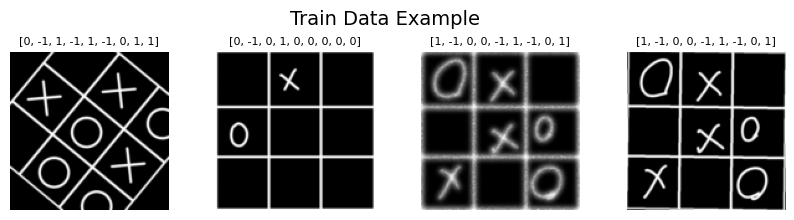

In [34]:
# 샘플 이미지 가져오기
images, labels = next(iter(train_loader))

# 시각화
plt.figure(figsize=(10, 2.5))  # 그림 간 간격 조절
for i in range(len(images)):
    plt.subplot(1, len(images), i + 1)
    plt.imshow(images[i][0], cmap='gray')
    label_list = [int(v.item()) for v in labels[i]]
    plt.title(f"{label_list}", fontsize=8)
    plt.axis('off')

plt.suptitle("Train Data Example", fontsize=14)
plt.subplots_adjust(wspace=0.3)  # 그림 간 간격 조정
plt.show()